Data                                                                                   int32
Veiculo                                                                                int32
Origem                                                                                 int32
Clientes unicos                                                                        int64
Setor                                                                                  int64
VL Tabela                                                                            float64
Vl Bruto                                                                             float64
Vl Liquido Final                                                                     float64
IPCA BR                                                                              float64
IPCA ES                                                                              float64
Taxa Ac. TRI % PIB                                                    

[100]	validation_0-rmse:33045.86470	validation_1-rmse:60827.96164
[200]	validation_0-rmse:23947.19653	validation_1-rmse:47732.33376
[300]	validation_0-rmse:21547.78944	validation_1-rmse:42180.88379
[400]	validation_0-rmse:20532.46813	validation_1-rmse:39573.84767
[500]	validation_0-rmse:19735.54777	validation_1-rmse:37986.37009
[600]	validation_0-rmse:19151.57612	validation_1-rmse:37160.81694
[700]	validation_0-rmse:18662.58456	validation_1-rmse:36341.19004
[800]	validation_0-rmse:18310.48742	validation_1-rmse:35901.40804
[900]	validation_0-rmse:17982.72467	validation_1-rmse:35663.67168
[1000]	validation_0-rmse:17714.90705	validation_1-rmse:35423.01563
[1100]	validation_0-rmse:17481.40938	validation_1-rmse:35147.21317
[1200]	validation_0-rmse:17240.95142	validation_1-rmse:35007.13399
[1300]	validation_0-rmse:17067.48417	validation_1-rmse:34844.69110
[1400]	validation_0-rmse:16908.41892	validation_1-rmse:34734.72378
[1499]	validation_0-rmse:16767.91642	validation_1-rmse:34609.98689
Mean

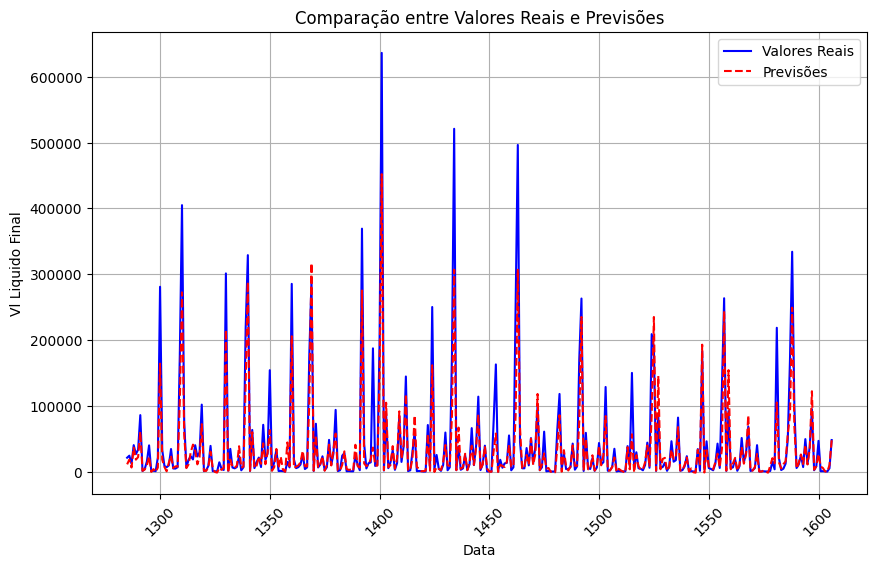

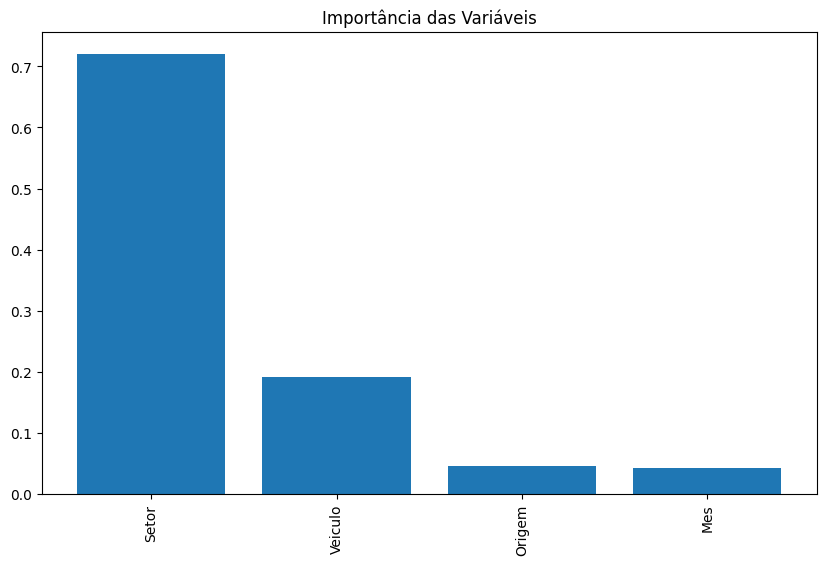

In [5]:
import pandas as pd
import xgboost as xgb
import numpy as np

df_veiculo_origem_radio = pd.read_csv('../df_veiculo_origem_radio.csv')
df_veiculo_origem_radio['Mes'] = pd.to_datetime(df_veiculo_origem_radio['Data']).dt.month
from sklearn.preprocessing import LabelEncoder

# Cria uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Seleciona as colunas categóricas para fazer o encoding
categorical_columns = df_veiculo_origem_radio.select_dtypes(include=['object']).columns

# Itera pelas colunas categóricas e aplica o label encoding
for col in categorical_columns:
    df_veiculo_origem_radio[col] = label_encoder.fit_transform(df_veiculo_origem_radio[col])
print(df_veiculo_origem_radio.dtypes)
df_veiculo_origem_radio.keys()
X = df_veiculo_origem_radio.drop(columns=['Vl Bruto','Vl Liquido Final','VL Tabela','PMC - Número-índice (2022=100) (Número-índice)/ ES',
       'PMC - Número-índice (2022=100) (Número-índice)/ BR',
       'PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ ES',
       'PMC - Número-índice com ajuste sazonal (2022=100) (Número-índice)/ BR',
       'PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ ES',
       'PMC - Variação mês/mês imediatamente anterior, com ajuste sazonal (M/M-1) (%)/ BR',
       'Taxa Ac. TRI % PIB','IPCA BR',
       'IPCA ES','Clientes unicos','Numero Contratos'])
y = df_veiculo_origem_radio['Vl Liquido Final']
X.keys()
X.dtypes
X.head()
X.drop(columns='Data',inplace=True)

# Divisão de dados em conjunto de treinamento e teste
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Treinando o modelo com o XGBoost
reg = xgb.XGBRegressor(
    base_score=0.5, 
    booster='gbtree',    
    n_estimators=1500,
    early_stopping_rounds=50,
    objective='reg:squarederror',  # Corrigido o objetivo
    max_depth=3,
    learning_rate=0.01
)
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#  Realize previsões com o modelo treinado
y_pred = reg.predict(X_test)

# Calcule as métricas de avaliação
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Exiba as métricas
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
import matplotlib.pyplot as plt

# Realize previsões com o modelo treinado
y_pred = reg.predict(X_test)

# Plote os valores reais e as previsões, utilizando as datas como eixo X
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores Reais', color='blue')
plt.plot(y_test.index, y_pred, label='Previsões', color='red', linestyle='--')
plt.title('Comparação entre Valores Reais e Previsões')
plt.xlabel('Data')
plt.ylabel('Vl Liquido Final')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotaciona as labels do eixo X para melhor visualização
plt.show()
importances = reg.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Importância das Variáveis')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.show()
